In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# raw_data 불러오기
raw_data = pd.read_csv("data/train.csv")


# X, y 나누기
y = raw_data["Transported"].map({True: "True", False: "False"})
X = raw_data.drop(columns="Transported")


# cabin column 세분화
cabin = X["Cabin"].str.split("/", expand=True)
cabin.columns = ["deck", "deck_num", "deck_side"]


# PassengerId column 세분화
pid = X["PassengerId"].str.split("_", expand=True)
pid.columns = ["group", "group_number"]
pid["group_number"] = pid["group_number"].apply(lambda x: x[1])

# cabin & passengerId 업데이트
X_new = pd.concat([X.drop(columns=["Cabin", "PassengerId"]), cabin, pid], axis=1)


for c_name in X.select_dtypes("float").columns.drop(labels=["Age"]):

    # numerical data를 log scale로 
    X_new[c_name][X_new[c_name] > 0] = np.log(X_new[c_name][X_new[c_name] > 0])

    # numerical data 이용 여부로 나누기
    X_new[f"{c_name}_cat"] = pd.cut(
        X_new[c_name], bins=[-1, 0.5, 999999], labels=["False", "True"]
    ).astype("object")


### feature 별 nan 개수

In [138]:
X_new.isna().sum()

HomePlanet          201
CryoSleep           217
Destination         182
Age                 179
VIP                 203
RoomService         181
FoodCourt           183
ShoppingMall        208
Spa                 183
VRDeck              188
Name                200
deck                199
deck_num            199
deck_side           199
group                 0
group_number          0
RoomService_cat     181
FoodCourt_cat       183
ShoppingMall_cat    208
Spa_cat             183
VRDeck_cat          188
dtype: int64

### row별 비어있는 개수

In [158]:
X_new.isna().sum(axis=1).value_counts()

0    6606
1     950
2     805
3     247
4      63
5      20
6       2
dtype: int64

`계획 : 채울 수 있는 것들은 모두 채워본 다음 0개 되지 않는 값들 모두 제거하기`

In [137]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HomePlanet        8492 non-null   object 
 1   CryoSleep         8476 non-null   object 
 2   Destination       8511 non-null   object 
 3   Age               8514 non-null   float64
 4   VIP               8490 non-null   object 
 5   RoomService       8512 non-null   float64
 6   FoodCourt         8510 non-null   float64
 7   ShoppingMall      8485 non-null   float64
 8   Spa               8510 non-null   float64
 9   VRDeck            8505 non-null   float64
 10  Name              8493 non-null   object 
 11  deck              8494 non-null   object 
 12  deck_num          8494 non-null   object 
 13  deck_side         8494 non-null   object 
 14  group             8693 non-null   object 
 15  group_number      8693 non-null   object 
 16  RoomService_cat   8512 non-null   object 


### object type EDA


In [140]:
# plot용 데이터셋 생성
obj_data = X_new.select_dtypes("object").drop(columns=["Name", "deck_num", "group"])

obj_data.head()


,HomePlanet,CryoSleep,Destination,VIP,deck,deck_side,group_number,RoomService_cat,FoodCourt_cat,ShoppingMall_cat,Spa_cat,VRDeck_cat
2333,Earth,False,TRAPPIST-1e,False,NaN,NaN,1,False,True,False,True,False
2589,Earth,False,TRAPPIST-1e,False,F,P,2,False,True,True,False,False
8302,Europa,True,55 Cancri e,False,C,S,4,False,False,False,False,False
8177,Mars,False,TRAPPIST-1e,False,F,P,2,NaN,True,True,True,False
500,Europa,True,55 Cancri e,False,C,P,2,False,False,False,False,False


In [173]:
for c in obj_data.columns:
    print(f"{c} : " ,obj_data[c].unique(), "| num of unique : ", len(obj_data[c].unique()))

print('\ncolumn 개수 : ',len(obj_data.columns))


HomePlanet :  ['Earth' 'Europa' 'Mars' nan] | num of unique :  4
CryoSleep :  [False True nan] | num of unique :  3
Destination :  ['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' nan] | num of unique :  4
VIP :  [False True nan] | num of unique :  3
deck :  [nan 'F' 'C' 'G' 'B' 'E' 'D' 'A' 'T'] | num of unique :  9
deck_side :  [nan 'P' 'S'] | num of unique :  3
group_number :  ['1' '2' '4' '3' '5' '6' '8' '7'] | num of unique :  8
RoomService_cat :  ['False' nan 'True'] | num of unique :  3
FoodCourt_cat :  ['True' 'False' nan] | num of unique :  3
ShoppingMall_cat :  ['False' 'True' nan] | num of unique :  3
Spa_cat :  ['True' 'False' nan] | num of unique :  3
VRDeck_cat :  ['False' nan 'True'] | num of unique :  3
Transported :  ['False' 'True'] | num of unique :  2

column 개수 :  13


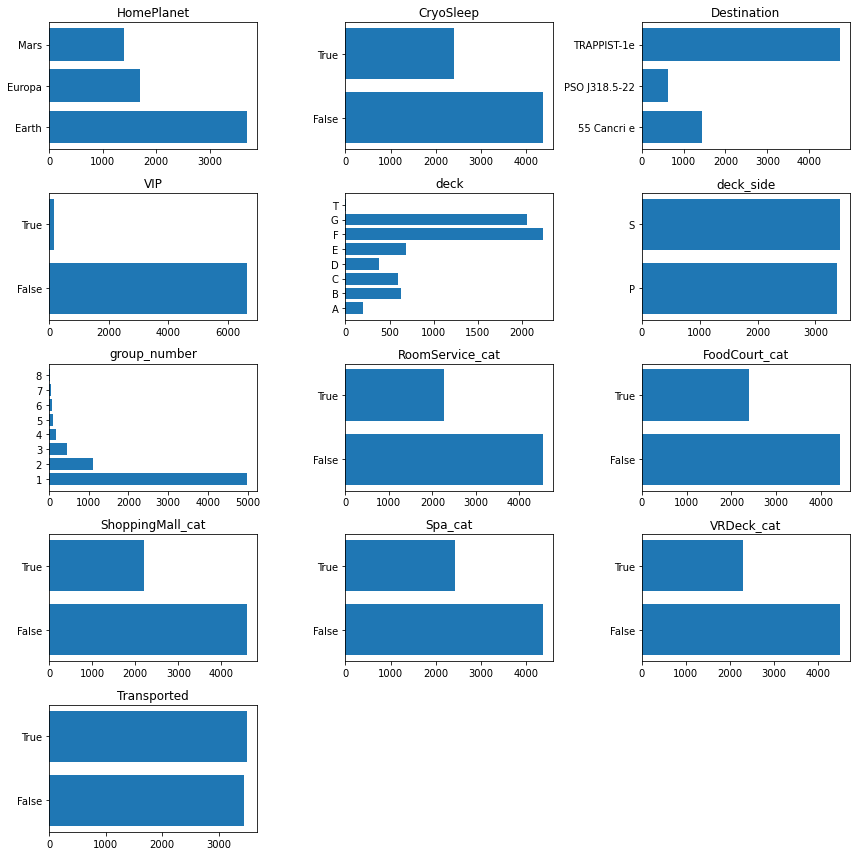

In [152]:
import matplotlib.pyplot as plt

obj_data["Transported"] = y

# feature 시각화
plt.figure(figsize=(12, 12))
for n, c in enumerate(obj_data.columns):
    plt.subplot(5, 3, n + 1)
    val_cnt = obj_data[c].value_counts().sort_index()
    plt.barh(list(map(str, val_cnt.index)), val_cnt)
    plt.title(c)
plt.tight_layout()
plt.show()


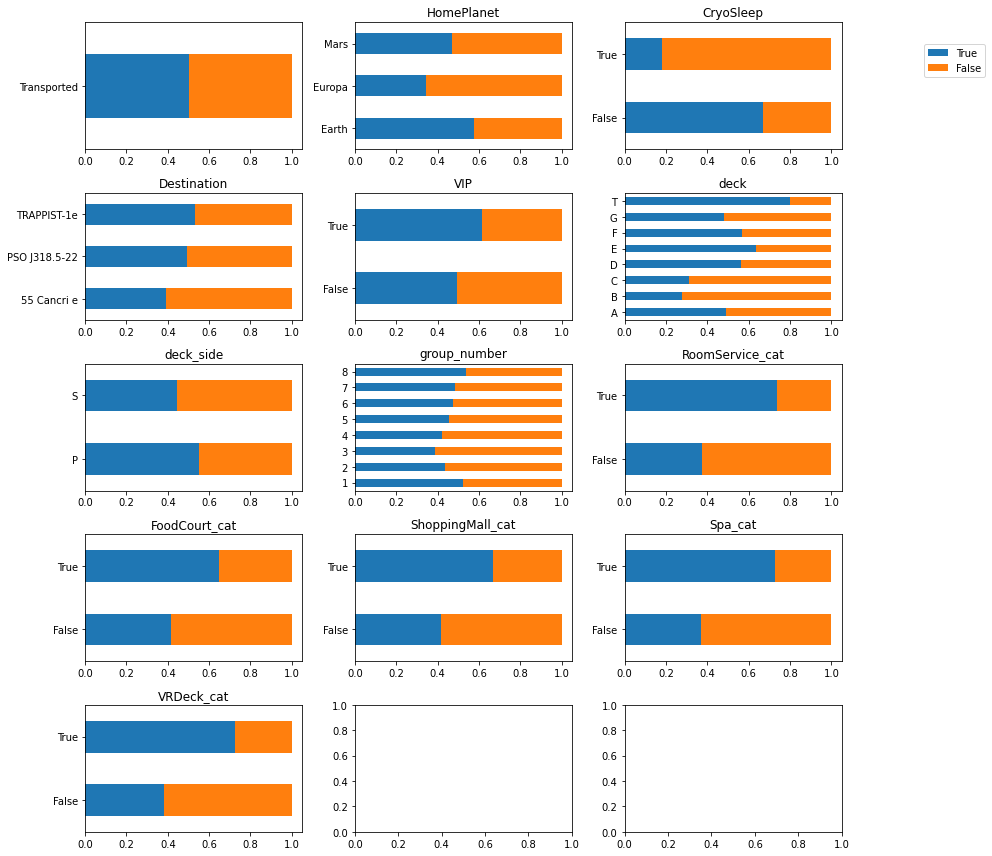

In [153]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))


for n, c_name in enumerate(obj_data.columns.drop(labels="Transported")):
    # r : row, c : column
    r, c = divmod(n + 1, 3)

    # 개별 feature와 target feature 비교
    group_df = obj_data.groupby([c_name, "Transported"]).size().unstack()

    # 개별 feature에 대해 target 별 비율 계산 및 시각화
    group_df.div(group_df.sum(axis=1), axis=0).plot(
        kind="barh", ax=axes[r, c], legend=False, stacked=True
    )
    axes[r, c].set_ylabel("")
    axes[r, c].set_title(c_name)


# Transported 비율 확인
target_data = obj_data["Transported"].value_counts()
pd.DataFrame(target_data).T.div(target_data.sum(), axis=0).plot(
    kind="barh", ax=axes[0, 0], stacked=True, legend=False
)


fig.legend(["True", "False"], bbox_to_anchor=(1.15, 0.95))
plt.tight_layout()
plt.show()


### numerical Data EDA


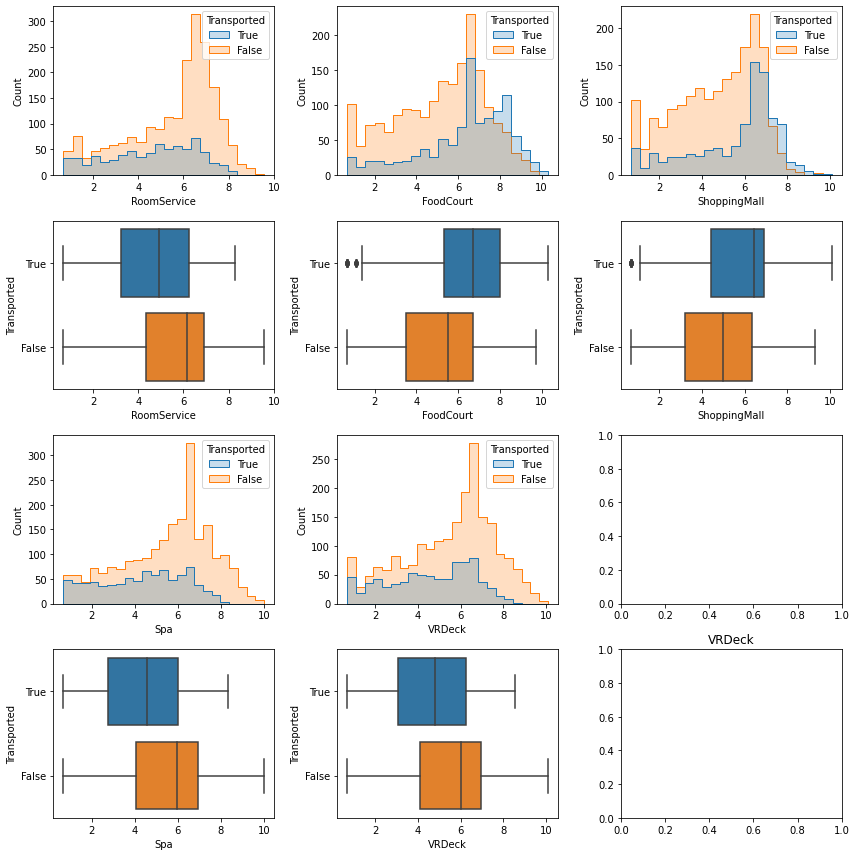

In [156]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot용 데이터셋 생성
float_data = X_new.select_dtypes("float")
float_data["Transported"] = y

float_data.head()

# feature 시각화
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
for n, c_name in enumerate(float_data.drop(columns=["Age", "Transported"])):
    r, c = divmod(n, 3)
    new_data = float_data[[c_name, "Transported"]][float_data[c_name] > 0]
    sns.histplot(data=new_data, x=c_name,hue="Transported",ax=axes[r * 2, c],element="step")
    sns.boxplot(data=new_data, x=c_name, y="Transported", ax=axes[(r * 2 + 1), c])
    plt.title(c_name)


plt.tight_layout()
plt.show()


In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

# save csv files
X_train.to_csv("data/X_train.csv")
y_train.to_csv("data/y_train.csv")
X_test.to_csv("data/X_test.csv")
y_test.to_csv("data/y_test.csv")